In [1]:
import math
import model as ty
import scipy.optimize as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import heat_transfer as bht

In [2]:
a = 0.001
delta = 0.00335

L_a = 0.020
N_ail = 75
k = 226

L_riser = 6*0.180

Q_f0 = -5.3/30

DT = -5.59

gam = Q_f0/(k*a*N_ail*delta*DT) 

In [11]:
def gamma_int(a,k,h,delta,L_a,N_ail,L_riser):
    Bi = ty.Biot(a,k,h,delta)

    alpha = math.sqrt(2*Bi)
    beta = math.sqrt(Bi/2)*(1/(1+a/delta))

    arg = (alpha*L_a)/a
    numerateur = (alpha/a)*math.sinh(arg) + ((beta*alpha)/a)*math.cosh(arg)
    denominateur = math.cosh(arg) + beta*math.sinh(arg)

    gamma = numerateur/denominateur

    gamma_int = (k*a*N_ail*delta)*gamma/L_riser

    return gamma_int

In [3]:
def gamma_val(h):
    Bi = ty.Biot(a,k,h,delta)

    alpha = math.sqrt(2*Bi)
    beta = math.sqrt(Bi/2)*(1/(1+a/delta))

    arg = (alpha*L_a)/a
    numerateur = (alpha/a)*math.sinh(arg) + ((beta*alpha)/a)*math.cosh(arg)
    denominateur = math.cosh(arg) + beta*math.sinh(arg)

    gamma = numerateur/denominateur

    gamma_int = (k*a*N_ail*delta)*gamma/L_riser

    gamma_back = delta/(1/(3.+h))

    return L_riser*(gamma_back+gamma_int)*DT - Q_f0

In [30]:
delta/(1/(1.4+3.))

0.014740000000000001

In [33]:
gamma_int(a,k,1.+1.4,delta,L_a,N_ail,L_riser)

0.029445932201323667

In [4]:
optim.fsolve(gamma_val,1.)

array([1.22830046])

In [5]:
# Define T_abs_list, T_amb and DT and create df and pth

T_abs_list = np.array([15,17,19,21,23,25,27,29,31,33,35])
T_abs_list = T_abs_list + np.array(len(T_abs_list)*[273.15])

T_amb = 25+273.15

DT = []

for i in range(len(T_abs_list)):
    DT.append(T_abs_list[i]-T_amb)

df = pd.DataFrame(index=DT)
pth = pd.DataFrame(index=DT)

In [6]:
# Compute heat transfer coefficient for flat plates

for i in range(len(T_abs_list)):
    df.loc[DT[i],'Flat plate facing downward'] = bht.back_h_simple(T_abs_list[i],T_amb,45,1.6)
    df.loc[DT[i],'Flat plate facing upward'] = bht.top_h_simple(T_abs_list[i],T_amb,45,1.6)

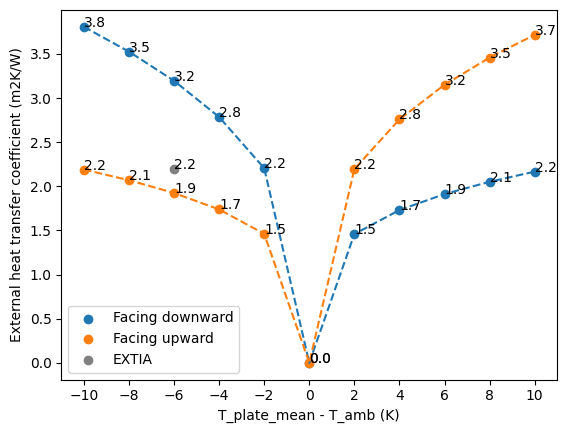

In [7]:
# Plot df

plt.scatter(DT,df['Flat plate facing downward'],label="Facing downward")
plt.scatter(DT,df['Flat plate facing upward'],label="Facing upward")
plt.plot(DT,df['Flat plate facing downward'],"--")
plt.plot(DT,df['Flat plate facing upward'],"--")

for i in range(len(df['Flat plate facing downward'])):
    plt.annotate(round(df['Flat plate facing downward'].iloc[i],1), (DT[i], df['Flat plate facing downward'].iloc[i]))
    plt.annotate(round(df['Flat plate facing upward'].iloc[i],1), (DT[i], df['Flat plate facing upward'].iloc[i]))

plt.scatter([-6],[2.2],label='EXTIA',c='grey')
plt.annotate(2.2,(-6,2.2))

plt.xticks(DT)
plt.xlabel('T_plate_mean - T_amb (K)')
plt.ylabel('External heat transfer coefficient (m2K/W)')
plt.legend()
plt.show()

In [8]:
# Compute heat transfer coefficients for fins

theta = 45.
longueur = 1.55
D_list = [0.001,0.005,0.0075,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.050,0.060,0.1,0.5]
L_fin = 0.020

for i in range(len(D_list)):

    for j in range(len(T_abs_list)):
        if j<=5:
            df.loc[DT[j],'Fins D = '+str(D_list[i])] = bht.back_h_fins(T_abs_list[j],T_amb,theta,longueur,D_list[i],L_fin)
        else:
            pass

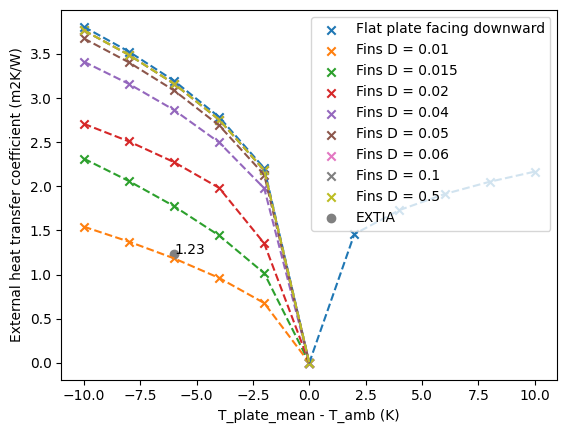

In [9]:
# list_col = np.array(df.columns)
list_col = ['Flat plate facing downward']+['Fins D = '+str(s) for s in [0.01,0.015,0.02,0.04,0.05,0.06,0.1,0.5]]

for k in range(len(list_col)):
    col = df[list_col[k]]
    plt.scatter(DT,col,label=col.name,marker='x')
    plt.plot(DT,col,"--")

    # for i in range(len(col)):
    #     plt.annotate(round(col.iloc[i],1), (DT[i], col.iloc[i]))

plt.scatter([-6],[1.23],label='EXTIA',c='grey')
plt.annotate(1.23,(-6,1.23))

plt.xlabel('T_plate_mean - T_amb (K)')
plt.ylabel('External heat transfer coefficient (m2K/W)')
plt.legend()
plt.show()

In [12]:
# Compute thermal power for fins

for i in range(len(D_list)):

    N_ail = (D_list[i]+300*delta)/(D_list[i]+a)

    for j in range(len(T_abs_list)):

        flat = 300*L_riser*df.loc[DT[j],'Fins D = '+str(D_list[i])]*delta*DT[j]
        pth.loc[DT[j],'Pth fins D = '+str(D_list[i])] = flat + 300*L_riser*gamma_int(a,k,df.loc[DT[j],'Fins D = '+str(D_list[i])],delta,L_a,N_ail,L_riser)*DT[j]

In [12]:
list_col = np.array(pth.columns)
print(list_col)

['Pth fins D = 0.001' 'Pth fins D = 0.005' 'Pth fins D = 0.0075'
 'Pth fins D = 0.01' 'Pth fins D = 0.015' 'Pth fins D = 0.02'
 'Pth fins D = 0.025' 'Pth fins D = 0.03' 'Pth fins D = 0.035'
 'Pth fins D = 0.04' 'Pth fins D = 0.05' 'Pth fins D = 0.1'
 'Pth fins D = 0.3']


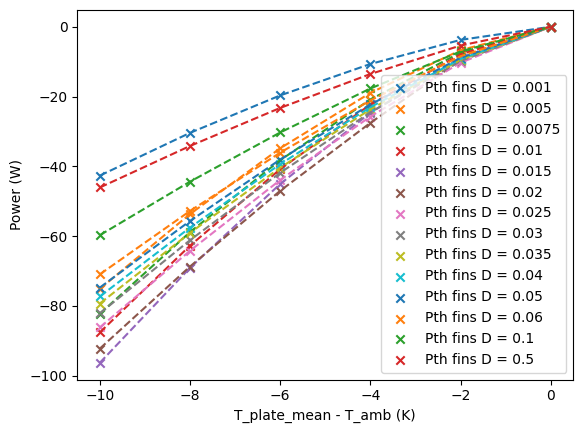

In [13]:
list_col = np.array(pth.columns)
# list_col = ['Pth fins D = 0.001','Pth fins D = 0.005','Pth fins D = 0.0075','Pth fins D = 0.01','Pth fins D = 0.015','Pth fins D = 0.02']

for k in range(len(list_col)):
    col = pth[list_col[k]]
    plt.scatter(DT,col,label=col.name,marker='x')
    plt.plot(DT,col,"--")

    # for i in range(len(col)):
    #     plt.annotate(round(col.iloc[i],1), (DT[i], col.iloc[i]))

plt.xlabel('T_plate_mean - T_amb (K)')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

In [20]:
pth

,Pth fins D = 0.001,Pth fins D = 0.005,Pth fins D = 0.0075,Pth fins D = 0.01,Pth fins D = 0.015,Pth fins D = 0.02,Pth fins D = 0.025,Pth fins D = 0.03,Pth fins D = 0.035,Pth fins D = 0.04,Pth fins D = 0.05,Pth fins D = 0.06,Pth fins D = 0.1,Pth fins D = 0.5
-10.0,-42.663889,-75.133857,-82.272435,-87.606497,-96.317094,-92.252242,-86.185061,-82.141354,-79.325826,-77.310407,-74.768988,-70.962374,-59.736154,-46.067503
-8.0,-30.405213,-53.680110,-58.856395,-62.742146,-69.103362,-68.719252,-64.196167,-61.178566,-59.075157,-57.567559,-55.662055,-52.800449,-44.398515,-34.168616
-6.0,-19.671815,-34.828808,-38.243513,-40.820487,-45.052171,-47.016721,-43.919544,-41.850832,-40.406977,-39.370568,-38.057074,-36.078808,-30.297809,-23.259069
-4.0,-10.668077,-18.950889,-20.845403,-22.284241,-24.656499,-27.539648,-25.723970,-24.509463,-23.660448,-23.049905,-22.273574,-21.100531,-17.689855,-13.537135
-2.0,-3.758824,-6.706207,-7.393658,-7.920167,-8.793322,-9.570850,-10.303504,-9.815629,-9.473818,-9.227391,-8.912624,-8.435151,-7.054441,-5.373336
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
-pth.loc[-6].iloc[0]

19.671814886866215

Text(0, 0.5, 'Power (W)')

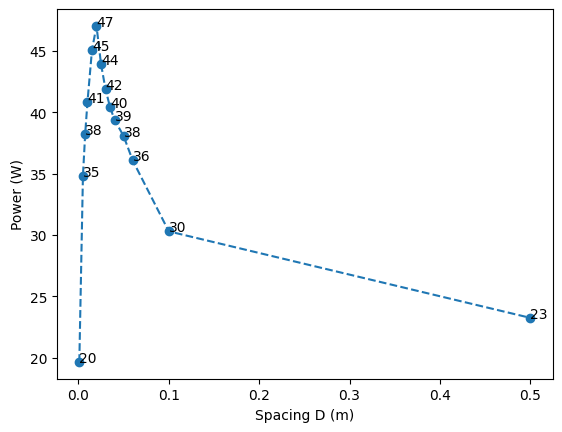

In [19]:
plt.scatter(D_list,-pth.loc[-6])
plt.plot(D_list,-pth.loc[-6],'--')

for i in range(len(D_list)):
    plt.annotate(round(-pth.loc[-6].iloc[i]), (D_list[i], -pth.loc[-6].iloc[i]))

plt.xlabel('Spacing D (m)')
plt.ylabel('Power (W)')

In [17]:
D_list

[0.001,
 0.005,
 0.0075,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.05,
 0.06,
 0.1,
 0.5]

In [23]:
3.196*L_riser*300*delta*6

25.8243192

In [25]:
300*L_riser*1.7*delta*6+35

48.73634

In [26]:
48-25

23

In [ ]:
for i in range(len(D_list)):

    

    for j in range(len(T_abs_list)):



        df.loc[DT[j],'Fins D = '+str(D_list[i])] = bht.back_h_fins(T_abs_list[j],T_amb,theta,longueur,D_list[i],L_fin)

In [ ]:
DT

In [ ]:
0.9*5.67*1E-8*(273.15*2+0.5+6.5)*((273.15+0.5)**2+(273.15+6.5)**2)